# Statistical detection of peaks of radio signals
This program takes each event and takes several parts from it:
 * _Selected window_: A window at which is expected that we might have a pulse, taking into account the cable delays from the center of the full window
 * _No selected window_: The rest of the window which was no selected.
 * _Random selected window_: One window randomly located with the same width as the selected window.
 * _Full window_: complete window of the full event

The final goal is to find possible peaks according to local variations of a statistical parameter: the standard deviation.

###### Import modules

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patch
import os
import csv
import scipy.stats as sct
import scipy.optimize as sco
from random import randrange
import modules_for_python.functions as fc
from modules_for_python.events import Event
from modules_for_python.CAENReader import WDReader
from modules_for_python.CAENReader import readChannels
from modules_for_python.auto_plots import histo_stats
from collections import Counter

##### List of files of interest (before fixing the voltage problem)
    * prueba_ext_211008_3h
    * waves_211011_0950_5h40
    * waves_211014_0925_2h54
    * waves_211014_1248_1h7
    * waves_211014_1410_2h44
    * waves_211014_2001_6h07
    * waves_211015_1209_0h58
    * waves_211015_1433_7h41
    * waves_211018_1828_2h52
    * waves_211019_0936_21h17
    * waves_211022_1220_69h20

##### List of files of interes (after fixing the voltage problem)
    * waves_211025_1200_27h35

##### List of files of interest (after fixing the voltage problem and decreasing the rate of triggers)
    * wavesh_211028_1302_21h54

###### Settings

In [40]:
### SETTINGS ######################################################################################

###### Settings to read data (options IN)
""" Legend:
        * in_dir -> name of input directory
        * ADC_ch -> number of ADC channels, equal to 2^Nbits
        * nsamp -> number of samples per event
        * deltaT -> real time separation between two samples
        * Vpp -> voltage peak to peak
        * ngroups -> number of groups to study data
        * Nevents -> number of events per group
"""
optin = {   'in_dir':       'wavesh_211029_1300_92h00',
            'ADC_ch':       int(2**14),
            'nsamp':        1030,
            'deltaT':       4,
            'Vpp':          0.5,
            'ngroups':      1,
            'Nevents':      'ind',
            }

cntr_of_fwin = optin['nsamp']/2 # Here is the trigger
# Delays induced by the travel of signals by the cable from antennas to digitizer:
cable_delays = np.array([576.5,574.8,403.0,403.0,286.5,284.7,209.0,207.2]) # ns
# Time of particles from antennas height to floor (where scintillator is)
particle_delay = 30 #ns
# Approximated time of delay of trigger
trigger_delay = 30 #ns
# Total expected pulse delay = cable_delays - particle_delay - trigger_delay
total_delay = cable_delays - particle_delay - trigger_delay
print('Total delay for each channel: ', total_delay, '\n')

win = 100 # width of window in ns. Must be multiple of 4
for i,item in optin.items(): print('%10s: %s' %(i,str(item)))


###### Settings to show and/or save results (options OUT)
optot = {'Show_hists':True,
         'Save_figs': True,
         'Save_stats':True
        }
######

if optot['Save_figs'] or optot['Save_stats']:
    cwd = os.getcwd()
    os.chdir(cwd+'/OUTPUTS')
    list_dir = os.listdir()
    if optin['in_dir'] not in list_dir:
        os.mkdir(optin['in_dir'])
        print(optin['in_dir'],' created in directory OUTPUTS')
    os.chdir(cwd)

Total delay for each channel:  [516.5 514.8 343.  343.  226.5 224.7 149.  147.2] 

    in_dir: wavesh_211029_1300_92h00
    ADC_ch: 16384
     nsamp: 1030
    deltaT: 4
       Vpp: 0.5
   ngroups: 1
   Nevents: ind


In [41]:
READ = readChannels('DATA/'+optin['in_dir'],Vpp=2.0)

file            wave0.dat   size       8113.0 KB
file            wave1.dat   size       8113.0 KB
file            wave2.dat   size       8113.0 KB
file            wave3.dat   size       8113.0 KB
file            wave4.dat   size       8113.0 KB
file            wave5.dat   size       8113.0 KB
file            wave6.dat   size       8113.0 KB
file            wave7.dat   size       8113.0 KB
 Reading file wave0.dat...
  INFO. Reading with header
 Reading file wave1.dat...
  INFO. Reading with header
 Reading file wave2.dat...
  INFO. Reading with header
 Reading file wave3.dat...
  INFO. Reading with header
 Reading file wave4.dat...
  INFO. Reading with header
 Reading file wave5.dat...
  INFO. Reading with header
 Reading file wave6.dat...
  INFO. Reading with header
 Reading file wave7.dat...
  INFO. Reading with header
 Working directory: /home/daniel/Documentos/HYBRID/Antenas


In [42]:
DATA = READ.data()

In [43]:
nevents = READ.nevents()
print('Number of events:', nevents)

Number of events: 3893


In [44]:
file_list = READ.files_list()
print(file_list)

['wave0.dat', 'wave1.dat', 'wave2.dat', 'wave3.dat', 'wave4.dat', 'wave5.dat', 'wave6.dat', 'wave7.dat']


###### Preparing statistics

In [45]:
STATS = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0}
RNDWI = {0:{}, 1:{}, 2:{}, 3:{}, 4:{}, 5:{}, 6:{}, 7:{}}
DIFFS = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0}
DESVS = {0:{}, 1:{}, 2:{}, 3:{}, 4:{}, 5:{}, 6:{}, 7:{}}

for wave in file_list:
    ich = int(wave[-5])
    
    ini = int(cntr_of_fwin) + int(total_delay[ich]/optin['deltaT']) #we assume a Hilbert pulse that begins just when the signal arrives to antennas
    fin = ini + win//optin['deltaT']
    print(' Ch ', ich)
    print('Index of start and end of window: ', ini,fin)
    print('Time of start and end of window:  ', ini*optin['deltaT'],fin*optin['deltaT'])
    STATS[ich] = {'sel': [],
                  'nosel': [],
                  'rand': [],
                  'norand': [],
                  'all': []} # statistics of SELected window, NO SELected window and full window (ALL)
    DIFFS[ich] = {'sw-nsw': [],
                  'rw-nrw': [],
                  'sw-rw': []}
    
    for iev,event0 in DATA[ich].items():
        event = event0[1]
        sel_window    = event[ini:fin]
        nosel_window1 = event[:ini]
        nosel_window2 = event[fin+1:]
        nosel_window  = np.concatenate((nosel_window1,nosel_window2))
        
        rand_ini = randrange(optin['nsamp']-win//optin['deltaT'])
        while rand_ini>(ini-win//optin['deltaT']) and rand_ini<fin:
            rand_ini = randrange(optin['nsamp']-win//optin['deltaT'])
        rand_fin = rand_ini + win//optin['deltaT'] # for each event a different window is randomly selected to know if the first selected window behaves differently
        RNDWI[ich][iev] = [rand_ini,rand_fin]
        
        rnd_window    = event[rand_ini:rand_fin]
        nornd_window1 = event[:rand_ini]
        nornd_window2 = event[rand_fin+1:]
        nornd_window  = np.concatenate((nornd_window1,nornd_window2))
        
        mean_all   = np.mean(event)
        std_all    = fc.sqdev(event,mean_all)
        std_sw     = fc.sqdev(sel_window,mean_all)
        std_nsw    = fc.sqdev(nosel_window,mean_all)
        std_rnd    = fc.sqdev(rnd_window,mean_all)
        std_nornd  = fc.sqdev(nornd_window,mean_all)
        
        STATS[ich]['sel'].append(std_sw)
        STATS[ich]['nosel'].append(std_nsw)
        STATS[ich]['rand'].append(std_rnd)
        STATS[ich]['norand'].append(std_nornd)
        STATS[ich]['all'].append(std_all)
        
        DIFFS[ich]['sw-nsw'].append(std_sw-std_nsw)
        DIFFS[ich]['rw-nrw'].append(std_rnd-std_nornd)
        DIFFS[ich]['sw-rw'].append(std_sw-std_rnd)
        
        desv = []
        for sample in sel_window:
            desvi = np.abs(sample-mean_all)/std_all
            desv.append(desvi)
        DESVS[ich][iev] = desv
        
print('\n Data construction is finished')

 Ch  0
Index of start and end of window:  644 669
Time of start and end of window:   2576 2676
 Ch  1
Index of start and end of window:  643 668
Time of start and end of window:   2572 2672
 Ch  2
Index of start and end of window:  600 625
Time of start and end of window:   2400 2500
 Ch  3
Index of start and end of window:  600 625
Time of start and end of window:   2400 2500
 Ch  4
Index of start and end of window:  571 596
Time of start and end of window:   2284 2384
 Ch  5
Index of start and end of window:  571 596
Time of start and end of window:   2284 2384
 Ch  6
Index of start and end of window:  552 577
Time of start and end of window:   2208 2308
 Ch  7
Index of start and end of window:  551 576
Time of start and end of window:   2204 2304

 Data construction is finished


### Showing one single event

In [100]:
ev = 1148

In [101]:
evento = READ.make_events(ev)

  INFO. Reading with header
  INFO. Reading with header
  INFO. Reading with header
  INFO. Reading with header
  INFO. Reading with header
  INFO. Reading with header
  INFO. Reading with header
  INFO. Reading with header


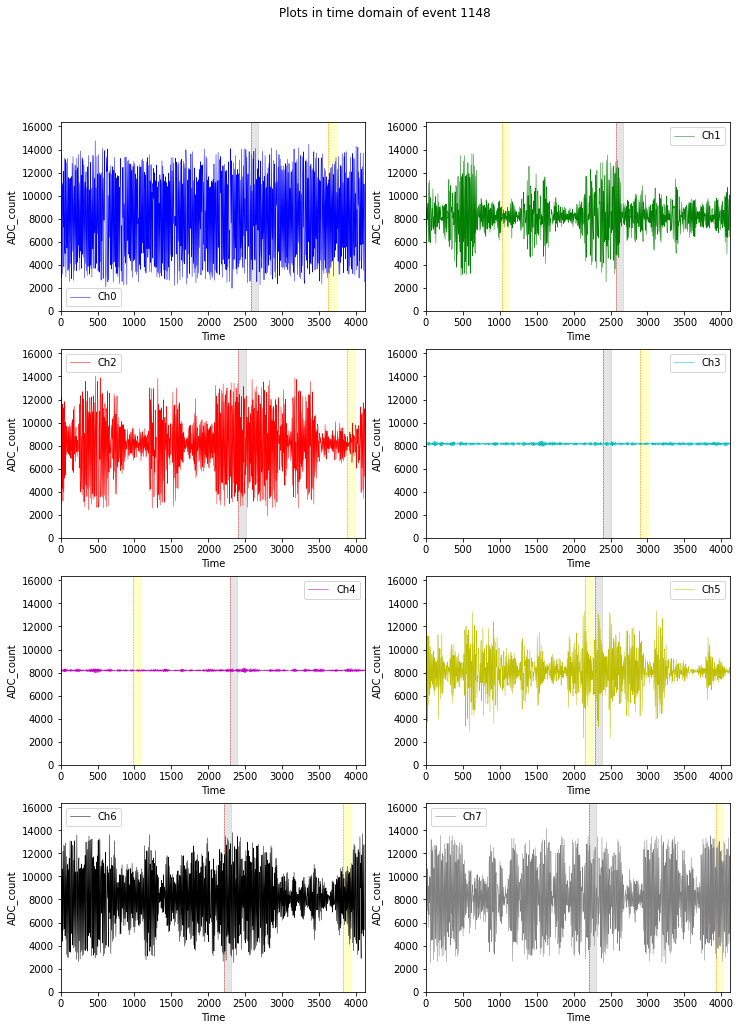

In [102]:
fig, ax = plt.subplots(4,2,figsize=(12,16))
fig.suptitle('Plots in time domain of event ' + str(ev))
fig.subplots_adjust(hspace=0.2,wspace=0.2)

for wave in file_list:
    ich = int(wave[-5])
    row = (ich)//2 ;  col = (ich)%2
    
    winini = int(optin['deltaT']*cntr_of_fwin) + total_delay[ich]
    (ax[row][col]).axvline(x=winini,linestyle='--',color='tab:red',linewidth=0.5)
    R = patch.Rectangle((winini,0),win,2**14,color='gray',alpha=0.2)
    (ax[row][col]).add_patch(R)
    
    randini = optin['deltaT']*RNDWI[ich][ev][0]
    randfin = optin['deltaT']*RNDWI[ich][ev][1]
    
    (ax[row][col]).axvline(x=randini,linestyle='--',color='tab:orange',linewidth=0.5)
    Rr = patch.Rectangle((randini,0),win,2**14,color='yellow',alpha=0.2)
    (ax[row][col]).add_patch(Rr)
    
    evento[ich].evn_display(ax[row][col])
    (ax[row][col]).set_xlabel('Time')
    (ax[row][col]).set_ylabel('ADC_count')
    (ax[row][col]).set_xlim(0,4120)
    (ax[row][col]).set_ylim(0,2**14)
    (ax[row][col]).legend()

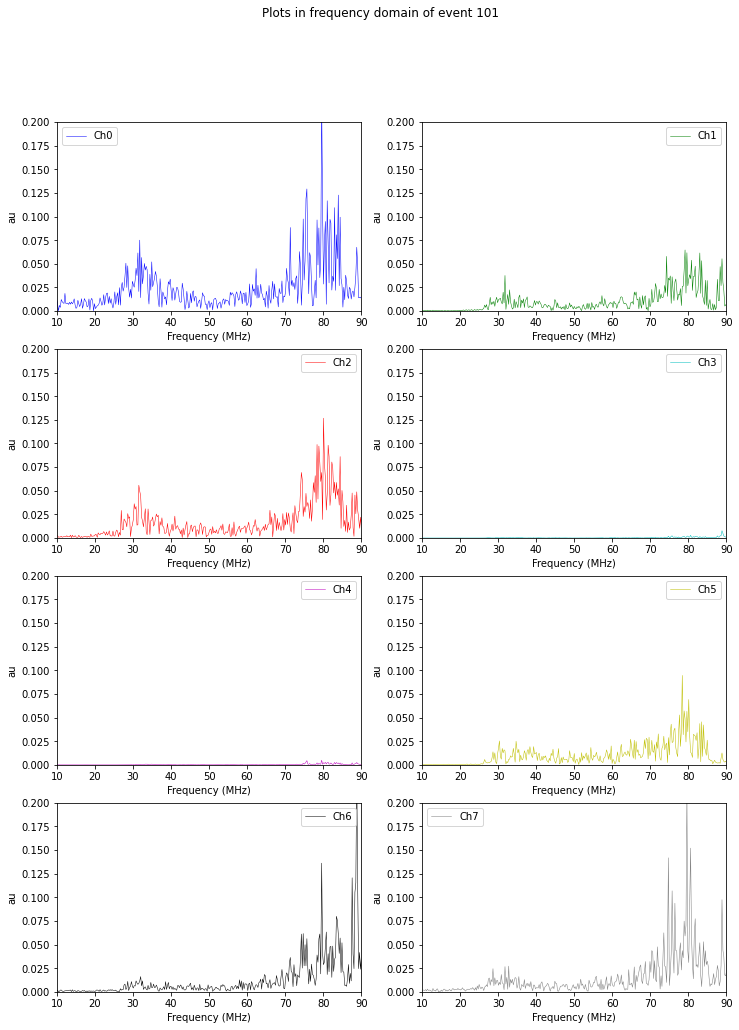

In [49]:
fig0, ax0 = plt.subplots(4,2,figsize=(12,16))
fig0.suptitle('Plots in frequency domain of event ' + str(ev))
fig0.subplots_adjust(hspace=0.2,wspace=0.2)

for wave in file_list:
    ich = int(wave[-5])
    row = (ich)//2 ;  col = (ich)%2
    
    evento[ich].evn_display_fourier(ax0[row][col])
    (ax0[row][col]).set_xlabel('Frequency (MHz)')
    (ax0[row][col]).set_ylabel('au')
    (ax0[row][col]).set_xlim(10,90)
    (ax0[row][col]).set_ylim(0,0.20)
    (ax0[row][col]).legend()

### Statistics of windows

#### Statistics of Standards Deviations

In [50]:
def parabola(x,A,x0,y0):
    return y0 + A*(x-x0)**2

Ch 0
xmin= 3090.43966894746
xmax= 4147.696262956283
Ch 1
xmin= -500.44598184740994
xmax= 3709.0643577386286
Ch 2
xmin= 21.39405686019079
xmax= 4939.393995350924
Ch 5
xmin= -1158.1414114712213
xmax= 4379.00754234796
Ch 6
xmin= 178.44337878224303
xmax= 4984.697701091844
Ch 7
xmin= -3.655034780792012
xmax= 5160.886363302268


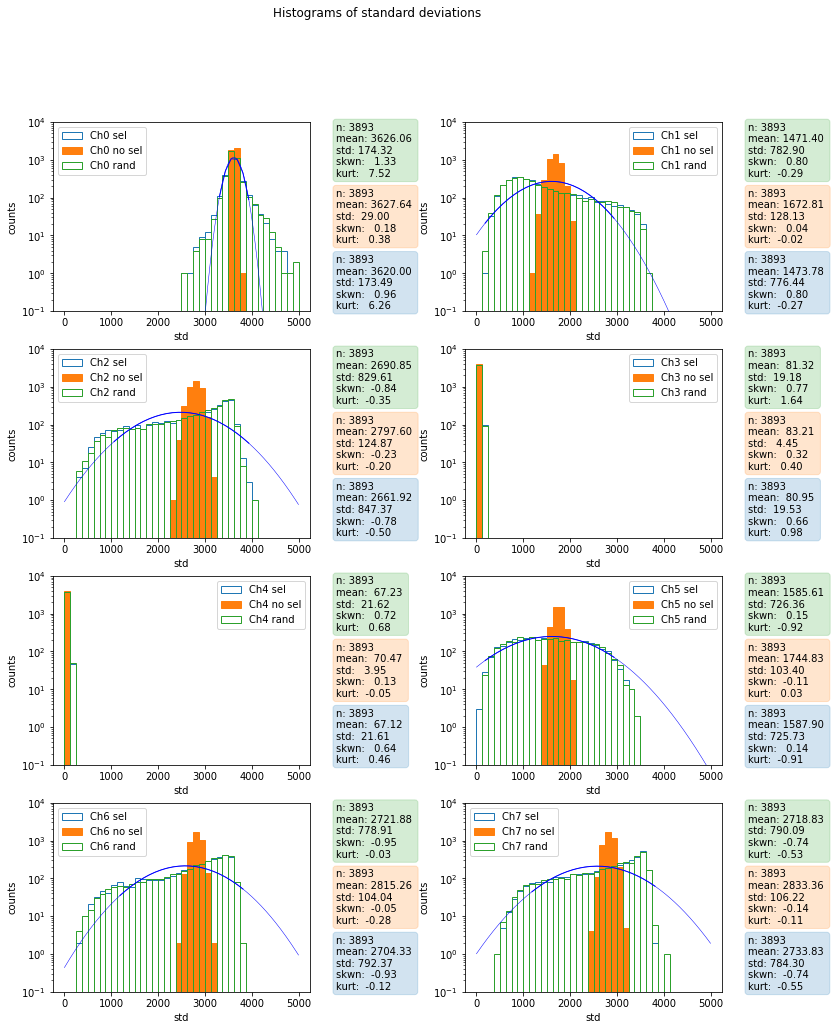

In [55]:
fig2, ax2 = plt.subplots(4,2,figsize=(12,16))
fig2.suptitle('Histograms of standard deviations')
fig2.subplots_adjust(hspace=0.2,wspace=0.6)

candidates = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[]}

for wave in file_list:
    ich = int(wave[-5])
    row = (ich)//2 ;  col = (ich)%2
    
    lower_limit = 0
    upper_limit = 5000
    plotear = histo_stats((STATS[ich]['sel'],STATS[ich]['nosel'],
                           STATS[ich]['rand']))
    tN, tbines, tpatches = plotear.plot_histo(ax2[row][col],
                       labels=('Ch'+str(ich)+' sel','Ch'+str(ich)+' no sel','Ch'+str(ich)+' rand'),
                       rang = ([lower_limit,upper_limit],[lower_limit,upper_limit],[lower_limit,upper_limit]),
                       bins = (40,40,40),
                       pos_stats=[[1.1,0.15],[1.1,0.5],[1.1,0.85]],
                       log=True,
                       style=(False,True,False))
    media = plotear.mean()[0]; desvest = plotear.stdev()[0]
    N = tN[0]; bines = tbines[0]; patches = tpatches[0]
    x = []; y=[]
    for i in range(len(N)):
        ctr_of_bin = (bines[i]+bines[i+1])/2
        if N[i]!=0 and np.abs(ctr_of_bin-media)<2*desvest:
            x.append(ctr_of_bin)
            y.append(np.log10(N[i]))
    xp = range(upper_limit)
    if len(x)>3:
        popt, pcov = sco.curve_fit(parabola,x,y)
        A,x0,y0 = popt
        xmin = (2*A*x0 + np.sqrt(4*A**2*x0**2-4*A*(A*x0**2+y0)))/(2*A) #Minimum allowed standard deviation. If less, the event automatically is suspicious to have had a hit
        xmax = (2*A*x0 - np.sqrt(4*A**2*x0**2-4*A*(A*x0**2+y0)))/(2*A) #Maximum allowed standard deviation. If more, the event automatically is suspicious to have had a hit
        print('Ch',ich)
        print('xmin=',xmin)
        print('xmax=',xmax)
        (ax2[row][col]).semilogy(xp,10**(parabola(xp,*popt)),color='b',linewidth=0.5)
        (ax2[row][col]).semilogy(x,10**(parabola(x,*popt)),color='b',linewidth=1.0)
        acc_factor = 1.0 # acceptation factor for width of parabola
        xm = (xmin+xmax)/2
        xmin = xm + acc_factor*(xmin-xm)
        xmax = xm + acc_factor*(xmax-xm)
        #candidates[ich] = []
        for iev,ev_stats in enumerate(STATS[ich]['sel']):
            if ev_stats<xmin or ev_stats>xmax:
                candidates[ich] += [iev,ev_stats]
    (ax2[row][col]).set_xlabel('std')
    (ax2[row][col]).set_ylabel('counts')
    (ax2[row][col]).legend()
    (ax2[row][col]).set_ylim(1e-1,1e4)

In [56]:
for ch,item in candidates.items():
    print(ch,item)

0 [114, 2986.1194596611736, 289, 4451.531478350671, 302, 3018.888926810036, 333, 4473.458719822408, 354, 2905.596859103675, 361, 4152.5115960572975, 498, 2842.4065015022165, 521, 4213.328054118236, 583, 4256.974663896226, 647, 4673.8034750130055, 716, 4444.449600202221, 736, 4256.697077015348, 767, 4213.203034202163, 795, 4162.698546515088, 818, 4153.516382864355, 850, 4360.44947229928, 858, 4264.449826474637, 921, 3063.1794579122566, 1064, 4220.190492734664, 1073, 4311.907559127353, 1161, 4326.947638272282, 1217, 2839.7150905197304, 1231, 4459.534971180517, 1252, 4173.458803079074, 1270, 2853.561701345695, 1370, 2904.7009107530157, 1437, 4192.678278541032, 1444, 4271.732610483082, 1465, 4299.780788898088, 1500, 4743.359523598614, 1593, 4285.46494460184, 1742, 4325.532351747552, 1762, 4167.203569419651, 1773, 2868.2887406786394, 1792, 2734.9374588769883, 1863, 4378.1169175767045, 1898, 4158.739794012025, 1902, 4257.777546603866, 1913, 2915.9559524533506, 1922, 4463.943808366431, 1966, 

In [57]:
print('SETS OF POSSIBLE CANDIDATES BY COINCIDENCES IN PAIRS OF CHANNELS N-S')
rest_of_ch = [1,2,5,6]
for chi in [1,2,5,6]:
    del rest_of_ch[0]
    for chj in rest_of_ch:
        possible = set(candidates[chi]) & set(candidates[chj])
        print(chi,chj,': ',possible)

SETS OF POSSIBLE CANDIDATES BY COINCIDENCES IN PAIRS OF CHANNELS N-S
1 2 :  set()
1 5 :  set()
1 6 :  set()
2 5 :  set()
2 6 :  set()
5 6 :  set()


In [58]:
print('SETS OF POSSIBLE CANDIDATES BY COINCIDENCES IN PAIRS OF CHANNELS E-W')
rest_of_ch = [0,3,4,7]
for chi in [0,3,4,7]:
    del rest_of_ch[0]
    for chj in rest_of_ch:
        possible = set(candidates[chi]) & set(candidates[chj])
        print(chi,chj,': ',possible)

SETS OF POSSIBLE CANDIDATES BY COINCIDENCES IN PAIRS OF CHANNELS E-W
0 3 :  set()
0 4 :  set()
0 7 :  set()
3 4 :  set()
3 7 :  set()
4 7 :  set()


### Statistics of differences between windows

#### Statistics of standard deviations

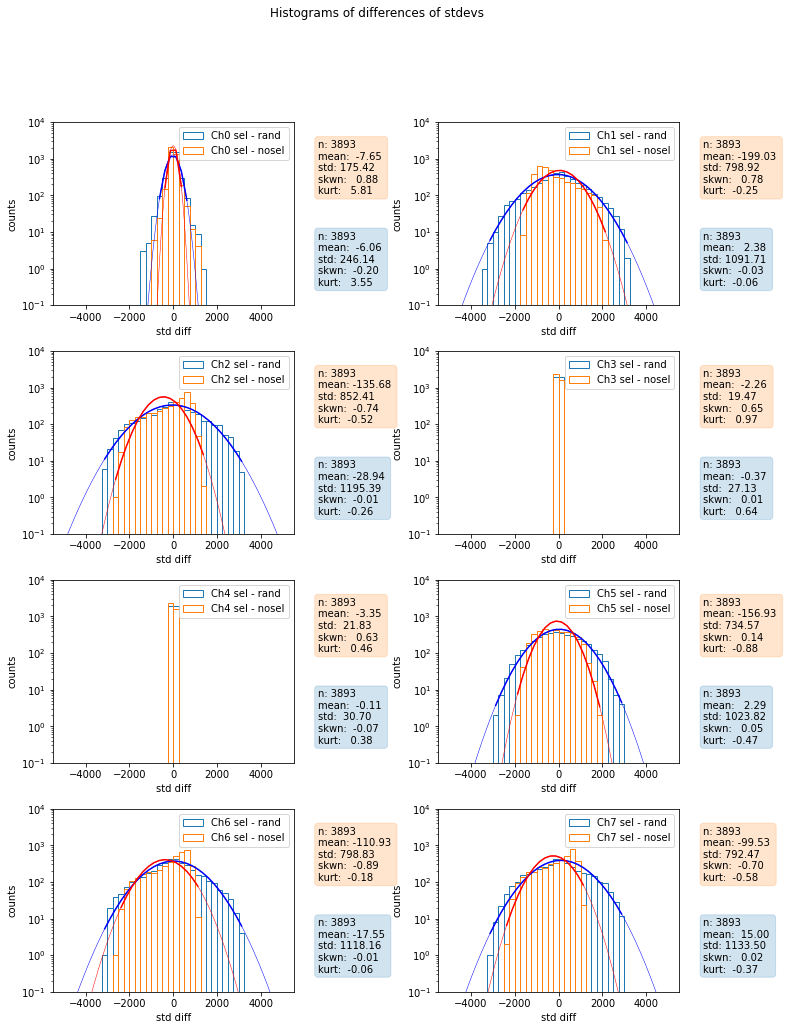

In [61]:
fig5, ax5 = plt.subplots(4,2,figsize=(12,16))
fig5.suptitle('Histograms of differences of stdevs')
fig5.subplots_adjust(hspace=0.25,wspace=0.6,right=0.85)

candidates1 = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[]} # candidates given by the difference sel-rand
candidates2 = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[]} # candidates given by the difference sel-nosel

lower_limit = -5000
upper_limit = 5000
#std_factors = []

for wave in file_list:
    ich = int(wave[-5])
    row = (ich)//2 ;  col = (ich)%2
    
    plotear = histo_stats((DIFFS[ich]['sw-rw'],DIFFS[ich]['sw-nsw']))
    tN, tbines, tpatches = plotear.plot_histo(ax5[row][col],
                       labels=('Ch'+str(ich)+' sel - rand','Ch'+str(ich)+' sel - nosel'),
                       rang = ([lower_limit,upper_limit],[lower_limit,upper_limit],[lower_limit,upper_limit]),
                       bins = (40,40,40),
                       pos_stats=[[1.1,0.25],[1.1,0.75]],
                       log = True)
    
    ### FIT AND CANDIDATES FOR DIFFERENCES SELECTED-RANDOM
    media = plotear.mean()[0]; desvest = plotear.stdev()[0]
    N = tN[0]; bines = tbines[0]; patches = tpatches[0]
    x = []; y=[]
    for i in range(len(N)):
        ctr_of_bin = (bines[i]+bines[i+1])/2
        if N[i]!=0 and np.abs(ctr_of_bin-media)<3*desvest:
            x.append(ctr_of_bin)
            y.append(np.log10(N[i]))
    xp = range(lower_limit,upper_limit)
    if len(x)>3:
        popt, pcov = sco.curve_fit(parabola,x,y)
        A,x0,y0 = popt
        (ax5[row][col]).semilogy(xp,10**(parabola(xp,*popt)),'b-',linewidth=0.5)
        (ax5[row][col]).semilogy(x,10**(parabola(x,*popt)),'b-')
        xmin = (2*A*x0 + np.sqrt(4*A**2*x0**2-4*A*(A*x0**2+y0)))/(2*A) #Minimum allowed standard deviation. If less, the event automatically is suspicious to have had a hit
        xmax = (2*A*x0 - np.sqrt(4*A**2*x0**2-4*A*(A*x0**2+y0)))/(2*A) #Maximum allowed standard deviation. If more, the event automatically is suspicious to have had a hit
        #candidates[ich] = []
        for iev,ev_stats in enumerate(DIFFS[ich]['sw-rw']):
            if ev_stats<xmin or ev_stats>xmax:
                candidates1[ich] += [iev,ev_stats]
        
    ### FIT AND CANDIDATES FOR DIFFERENCES SELECTED-NO SELECTED
    media = plotear.mean()[1]; desvest = plotear.stdev()[1]
    N = tN[1]; bines = tbines[1]; patches = tpatches[1]
    x = []; y=[]
    for i in range(len(N)):
        ctr_of_bin = (bines[i]+bines[i+1])/2
        if N[i]!=0 and np.abs(ctr_of_bin-media)<3*desvest:
            x.append(ctr_of_bin)
            y.append(np.log10(N[i]))
    xp = range(lower_limit,upper_limit)
    if len(x)>3:
        popt, pcov = sco.curve_fit(parabola,x,y)
        A,x0,y0 = popt
        (ax5[row][col]).semilogy(xp,10**(parabola(xp,*popt)),'r-',linewidth=0.5)
        (ax5[row][col]).semilogy(x,10**(parabola(x,*popt)),'r-')
        xmin = (2*A*x0 + np.sqrt(4*A**2*x0**2-4*A*(A*x0**2+y0)))/(2*A) #Minimum allowed standard deviation. If less, the event automatically is suspicious to have had a hit
        xmax = (2*A*x0 - np.sqrt(4*A**2*x0**2-4*A*(A*x0**2+y0)))/(2*A) #Maximum allowed standard deviation. If more, the event automatically is suspicious to have had a hit
        #candidates[ich] = []
        for iev,ev_stats in enumerate(DIFFS[ich]['sw-nsw']):
            if ev_stats<xmin or ev_stats>xmax:
                candidates2[ich] += [iev,ev_stats]
    
    (ax5[row][col]).set_xlabel('std diff')
    (ax5[row][col]).set_ylabel('counts')
    (ax5[row][col]).legend()
    (ax5[row][col]).set_ylim(1e-1,1e4)
    
#if optot['Save_figs']: plt.savefig('OUTPUTS/'+optin['in_dir']+'/'+'stds_stats.jpg',dpi=200); print('Figure saved!')

In [62]:
print(candidates1)

{0: [182, -1064.5408509553176, 289, 1019.4980340292022, 642, 1014.6723183572094, 647, 1075.7399518881425, 668, -1312.4093368556378, 850, 1298.533021331345, 1220, -1321.466992211947, 1370, -1105.653430925859, 1500, 1171.4089393263998, 1976, 1030.221685252901, 2066, 1189.6105300173267, 2221, -1017.1878802705601, 2590, -1387.3403188769053, 2609, 1027.8904136536603, 2920, -1245.656755134144, 3544, -1199.458529053728, 3827, 1033.70310088113, 3835, 1004.2040382398868], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: []}


In [63]:
print(candidates2)

{0: [289, 844.3357257525299, 333, 860.0718621392925, 354, -705.7435388944832, 498, -760.009886771189, 647, 1075.887853417932, 716, 814.5287634148754, 850, 754.3977825708012, 858, 668.6576289402851, 1073, 656.4642987562806, 1161, 724.8164481161125, 1217, -802.970468852634, 1231, 815.7376880935931, 1270, -768.5039031687884, 1370, -747.8679857993443, 1465, 668.242806803757, 1500, 1094.08604086379, 1593, 677.8218826074826, 1742, 656.5368848530438, 1773, -747.8406971019604, 1792, -856.1952603089103, 1863, 726.2444405851252, 1902, 655.4828233956546, 1913, -725.1879927167633, 1922, 835.6883681966387, 1976, 1011.2016247804072, 2066, 1018.8300568318787, 2124, 708.7006260185208, 2386, 933.2073926914695, 2498, 720.2658995721226, 2609, 929.0400106820766, 2623, 690.0967771461883, 2878, 689.241003845616, 2915, -662.1242981754694, 2920, -651.450429143501, 2973, 810.5531981992103, 3086, 793.5625488591959, 3179, -991.3967108776092, 3457, 683.3629073156758, 3529, -834.4488324445692, 3551, 956.2649163459

In [64]:
print('SETS OF POSSIBLE CANDIDATES BY COINCIDENCES IN PAIRS OF CHANNELS N-S. SEL-RAND')
rest_of_ch = [1,2,5,6]
for chi in [1,2,5,6]:
    del rest_of_ch[0]
    for chj in rest_of_ch:
        possible = set(candidates1[chi]) & set(candidates1[chj])
        print(chi,chj,': ',possible)

SETS OF POSSIBLE CANDIDATES BY COINCIDENCES IN PAIRS OF CHANNELS N-S. SEL-RAND
1 2 :  set()
1 5 :  set()
1 6 :  set()
2 5 :  set()
2 6 :  set()
5 6 :  set()


In [65]:
print('SETS OF POSSIBLE CANDIDATES BY COINCIDENCES IN PAIRS OF CHANNELS E-W. SEL-RAND')
rest_of_ch = [0,3,4,7]
for chi in [0,3,4,7]:
    del rest_of_ch[0]
    for chj in rest_of_ch:
        possible = set(candidates1[chi]) & set(candidates1[chj])
        print(chi,chj,': ',possible)

SETS OF POSSIBLE CANDIDATES BY COINCIDENCES IN PAIRS OF CHANNELS E-W. SEL-RAND
0 3 :  set()
0 4 :  set()
0 7 :  set()
3 4 :  set()
3 7 :  set()
4 7 :  set()


In [66]:
print('SETS OF POSSIBLE CANDIDATES BY COINCIDENCES IN PAIRS OF CHANNELS N-S. SEL-NOSEL')
rest_of_ch = [1,2,5,6]
for chi in [1,2,5,6]:
    del rest_of_ch[0]
    for chj in rest_of_ch:
        possible = set(candidates2[chi]) & set(candidates2[chj])
        print(chi,chj,': ',possible)

SETS OF POSSIBLE CANDIDATES BY COINCIDENCES IN PAIRS OF CHANNELS N-S. SEL-NOSEL
1 2 :  set()
1 5 :  set()
1 6 :  set()
2 5 :  set()
2 6 :  set()
5 6 :  set()


In [67]:
print('SETS OF POSSIBLE CANDIDATES BY COINCIDENCES IN PAIRS OF CHANNELS E-W. SEL-NOSEL')
rest_of_ch = [0,3,4,7]
for chi in [0,3,4,7]:
    del rest_of_ch[0]
    for chj in rest_of_ch:
        possible = set(candidates2[chi]) & set(candidates2[chj])
        print(chi,chj,': ',possible)

SETS OF POSSIBLE CANDIDATES BY COINCIDENCES IN PAIRS OF CHANNELS E-W. SEL-NOSEL
0 3 :  set()
0 4 :  set()
0 7 :  set()
3 4 :  set()
3 7 :  set()
4 7 :  set()


### Individual deviations

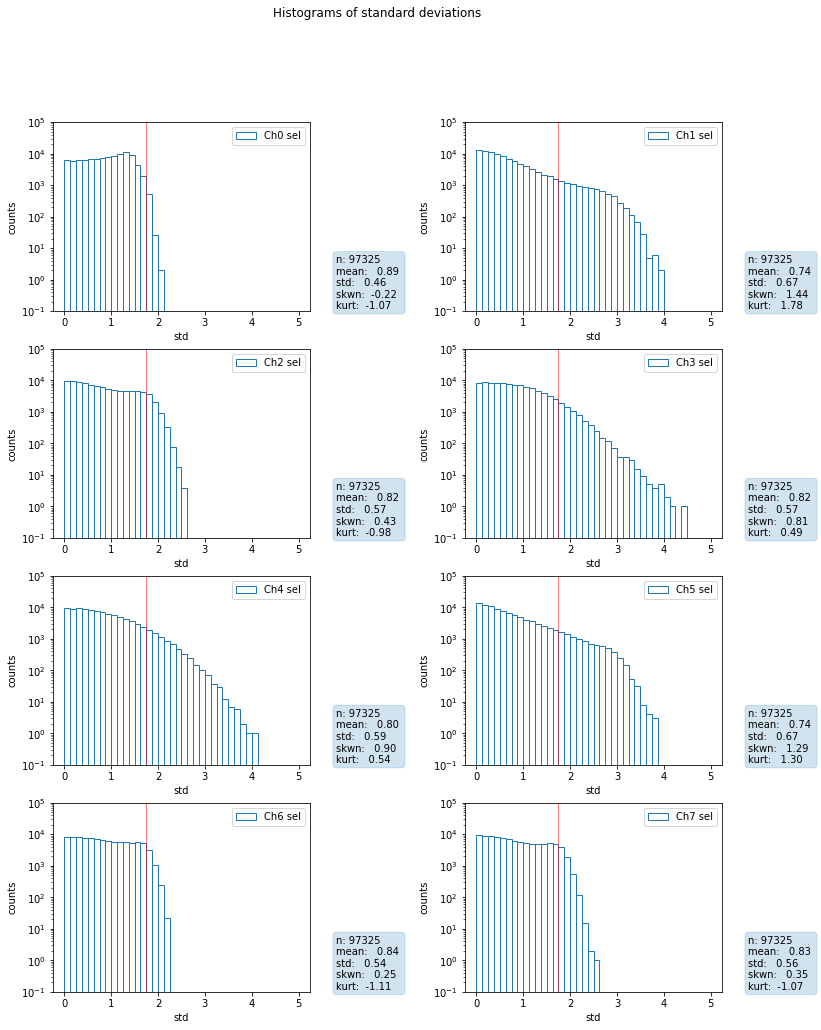

In [72]:
fig7, ax7 = plt.subplots(4,2,figsize=(12,16))
fig7.suptitle('Histograms of standard deviations')
fig7.subplots_adjust(hspace=0.2,wspace=0.6)

candidates3 = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[]}

xmaxs = [2,4,2.5,3.5,4,4,2.5,2.5]
xmaxs = [2,2,2,2,2,2,2,2]
lower_limit = 0
upper_limit = 5

for wave in file_list:
    ich = int(wave[-5])
    row = (ich)//2 ;  col = (ich)%2
    
    desvs = []
    for iev,event in DESVS[ich].items():
        #print(event)
        desvs += event
    plotear = histo_stats((desvs,))
    tN, tbines, tpatches = plotear.plot_histo(ax7[row][col],
                       labels=('Ch'+str(ich)+' sel',),
                       rang = ([lower_limit,upper_limit],[lower_limit,upper_limit],[lower_limit,upper_limit]),
                       bins = (40,),
                       pos_stats=[[1.1,0.15]],
                       log=True
                                      )
    xmax = np.sqrt(3) # we consider that a sample is suspicious if its deviation from the mean is more than 1/std(square dist.) = sqrt(3)
    (ax7[row][col]).axvline(x=xmax,color='red',linewidth=0.5)
    
    for iev,event in DESVS[ich].items():
        for sample in event:
            if sample>xmaxs[ich]:
                candidates3[ich] += [iev,sample]
    
    (ax7[row][col]).set_xlabel('std')
    (ax7[row][col]).set_ylabel('counts')
    (ax7[row][col]).legend()
    (ax7[row][col]).set_ylim(1e-1,1e5)

In [73]:
print(candidates3)

{0: [2271, 2.013822995948947, 3856, 2.006928254959203], 1: [0, 2.0666895497136695, 0, 2.2267339277848697, 0, 2.865359352715458, 3, 2.018841912944571, 6, 2.621922213852967, 6, 3.0352333027630127, 6, 2.136769464266325, 6, 2.7032620637790665, 6, 2.115037443293703, 6, 2.135527634496461, 6, 3.1205168664534093, 6, 2.4733053318995006, 11, 2.187640684542172, 11, 2.7047810134746713, 18, 2.1151702225891036, 18, 2.201062984110739, 18, 2.78463983310164, 18, 2.9393548651659716, 18, 2.5093199089035227, 18, 2.0604633198881324, 18, 2.404605514628946, 18, 2.538734064598629, 20, 2.12678227975649, 20, 2.410519408672378, 20, 2.0305834787067356, 22, 2.1850511253185694, 22, 2.0810947399518347, 22, 2.108126406528915, 22, 2.105361609045757, 25, 2.540776602119922, 25, 2.132541046586059, 26, 2.0923797926963354, 27, 2.5276974133726595, 27, 2.1904422440579645, 29, 2.542062875321275, 29, 2.006468398758233, 38, 2.341100466691775, 38, 2.2692043932754036, 38, 2.288268369264241, 38, 2.353280229129088, 39, 2.4745808543

In [75]:
clusters = {}
for ch,lista in candidates3.items():
    cluster = [item for item, count in Counter(lista).items() if count > 1]
    clusters[ch] = cluster
    print(ch,cluster)
    #print(cluster)

0 []
1 [0, 6, 11, 18, 20, 22, 25, 27, 29, 38, 39, 40, 47, 48, 50, 51, 55, 68, 71, 72, 73, 75, 76, 81, 83, 84, 85, 99, 101, 106, 118, 122, 125, 128, 132, 138, 139, 140, 141, 151, 153, 154, 161, 162, 166, 168, 169, 171, 173, 177, 187, 188, 198, 201, 203, 206, 207, 208, 211, 2.425465026405651, 219, 222, 227, 228, 230, 232, 233, 241, 244, 245, 252, 255, 257, 262, 272, 277, 287, 288, 297, 298, 299, 303, 308, 320, 327, 328, 330, 333, 334, 335, 336, 339, 340, 349, 353, 356, 359, 364, 365, 372, 377, 378, 3.115523869042826, 383, 384, 386, 389, 392, 396, 401, 407, 416, 421, 426, 429, 431, 434, 437, 441, 447, 452, 455, 457, 461, 462, 464, 471, 472, 473, 474, 475, 477, 479, 484, 485, 487, 494, 495, 496, 499, 502, 503, 505, 508, 512, 520, 521, 523, 524, 528, 536, 538, 540, 549, 550, 551, 559, 562, 563, 568, 569, 575, 579, 581, 583, 593, 596, 597, 599, 603, 605, 606, 618, 624, 629, 635, 637, 640, 647, 648, 652, 657, 660, 662, 664, 665, 669, 670, 671, 672, 673, 675, 678, 679, 681, 687, 688, 694, 2.82

In [77]:
print('SETS OF POSSIBLE CANDIDATES BY COINCIDENCES OF CLUSTERS IN PAIRS OF CHANNELS N-S. DESVS')
rest_of_ch = [1,2,5,6]
for chi in [1,2,5,6]:
    del rest_of_ch[0]
    for chj in rest_of_ch:
        possible = set(clusters[chi]) & set(clusters[chj])
        print(chi,chj,': ',possible)

SETS OF POSSIBLE CANDIDATES BY COINCIDENCES OF CLUSTERS IN PAIRS OF CHANNELS N-S. DESVS
1 2 :  {3079, 1042, 2066, 3606, 2081, 2594, 3106, 1060, 549, 2086, 1580, 559, 1073, 2098, 2612, 2613, 1086, 3136, 3138, 2118, 1102, 81, 2648, 1627, 1631, 3174, 2152, 3177, 2158, 2163, 3193, 635, 1148, 125, 3195, 1664, 647, 3208, 3209, 3214, 3220, 1686, 151, 3738, 2717, 670, 3231, 2721, 1699, 1190, 679, 2729, 3759, 3766, 1719, 2232, 3255, 2746, 1727, 3778, 3271, 712, 3273, 203, 716, 3789, 718, 207, 208, 2765, 1747, 1239, 728, 219, 732, 2267, 2268, 2782, 3298, 742, 1767, 2801, 3316, 2301, 1790, 2814, 1289, 3337, 2316, 3852, 2320, 2836, 3873, 3364, 1829, 2348, 1840, 3377, 1844, 2870, 823, 2362, 2368, 835, 327, 1863, 3402, 1359, 2898, 1365, 1367, 2907, 860, 865, 867, 3435, 1900, 1904, 2424, 1401, 890, 383, 384, 2439, 2450, 1941, 2454, 2966, 1944, 923, 2973, 1440, 1953, 930, 934, 1958, 3503, 3001, 3003, 2498, 2511, 3030, 471, 986, 3550, 3554, 3559, 494, 3058, 1526, 1530}
1 5 :  {2049, 2050, 2054, 11, 18,

In [78]:
print('SETS OF POSSIBLE CANDIDATES BY COINCIDENCES IN PAIRS OF CHANNELS E-W. DESVS')
rest_of_ch = [0,3,4,7]
for chi in [0,3,4,7]:
    del rest_of_ch[0]
    for chj in rest_of_ch:
        possible = set(clusters[chi]) & set(clusters[chj])
        print(chi,chj,': ',possible)

SETS OF POSSIBLE CANDIDATES BY COINCIDENCES IN PAIRS OF CHANNELS E-W. DESVS
0 3 :  set()
0 4 :  set()
0 7 :  set()
3 4 :  {3584, 514, 3592, 1033, 2062, 1048, 1049, 1565, 1566, 1055, 3613, 545, 1533, 35, 2596, 1060, 2087, 1069, 563, 566, 59, 1597, 3137, 3649, 583, 1097, 2124, 1109, 1120, 1633, 3684, 102, 106, 3183, 115, 118, 2681, 2170, 1658, 638, 2177, 1665, 2691, 132, 1669, 138, 2188, 2192, 145, 1168, 2200, 1178, 3227, 1182, 2207, 1701, 2214, 2216, 2217, 173, 1197, 687, 1201, 690, 693, 3257, 2747, 1211, 3260, 3771, 1724, 1727, 3267, 1739, 3278, 1235, 3798, 2777, 732, 2780, 3805, 1760, 3810, 2789, 2278, 2793, 3305, 1263, 243, 3316, 1272, 1788, 3838, 3839, 769, 772, 1284, 1287, 1801, 783, 2836, 3351, 1819, 797, 287, 3871, 289, 2854, 3366, 2347, 1327, 822, 1846, 1337, 2363, 1851, 2367, 2879, 2881, 1343, 835, 3397, 1863, 1865, 2385, 1874, 339, 854, 2395, 3420, 1373, 354, 2403, 866, 1893, 2407, 363, 1387, 1390, 1905, 2932, 1397, 2935, 890, 1917, 1406, 1920, 386, 387, 1925, 1415, 2952, 398,

In [83]:
print('SETS OF POSSIBLE CANDIDATES BY COINCIDENCES OF CLUSTERS IN GROUPS>2 OF CHANNELS N-S. DESVS')
rest_of_ch = [1,2,5,6]
print('1 2 5: ', set(clusters[1]) & set(clusters[2]) & set(clusters[5]))
print('1 2 6: ', set(clusters[1]) & set(clusters[2]) & set(clusters[6]))
print('2 5 6: ', set(clusters[1]) & set(clusters[2]) & set(clusters[6]))
print('1 2 5 6: ', set(clusters[1]) & set(clusters[2]) & set(clusters[5]) & set(clusters[6]))

SETS OF POSSIBLE CANDIDATES BY COINCIDENCES OF CLUSTERS IN GROUPS>2 OF CHANNELS N-S. DESVS
1 2 5:  {2066, 3606, 3106, 2594, 549, 2086, 2098, 2612, 2613, 1086, 3136, 3138, 2118, 2648, 1631, 3174, 2152, 2158, 2163, 3193, 3195, 1148, 1664, 3209, 3214, 151, 3738, 2717, 670, 3231, 1699, 679, 2729, 3759, 3766, 2232, 3778, 3271, 712, 203, 716, 3789, 718, 207, 208, 2765, 1747, 219, 732, 2268, 742, 3316, 2301, 2814, 1790, 1289, 3337, 2316, 3852, 2320, 2836, 3364, 1829, 1844, 2870, 823, 2362, 3402, 2898, 1367, 2907, 860, 3435, 1900, 1904, 383, 384, 2439, 2450, 1941, 2454, 1944, 923, 2973, 1953, 934, 3503, 2511, 3030, 471, 986, 494, 1530}
1 2 6:  {384, 1699, 3214, 1747, 2454, 1148}
2 5 6:  {384, 1699, 3214, 1747, 2454, 1148}
1 2 5 6:  {384, 1699, 3214, 1747, 2454, 1148}


In [84]:
print('SETS OF POSSIBLE CANDIDATES BY COINCIDENCES OF CLUSTERS IN GROUPS>2 OF CHANNELS E-W. DESVS')
rest_of_ch = [0,3,4,7]
print('0 3 4: ', set(clusters[0]) & set(clusters[3]) & set(clusters[4]))
print('0 3 7: ', set(clusters[0]) & set(clusters[3]) & set(clusters[7]))
print('3 4 7: ', set(clusters[3]) & set(clusters[4]) & set(clusters[7]))
print('0 3 4 7: ', set(clusters[0]) & set(clusters[3]) & set(clusters[4]) & set(clusters[7]))

SETS OF POSSIBLE CANDIDATES BY COINCIDENCES OF CLUSTERS IN GROUPS>2 OF CHANNELS E-W. DESVS
0 3 4:  set()
0 3 7:  set()
3 4 7:  {2403, 2596, 1669, 422, 1863, 783, 3316, 3509, 2012}
0 3 4 7:  set()


In [71]:
print('SETS OF POSSIBLE CANDIDATES BY COINCIDENCES IN PAIRS OF CHANNELS N-S. DESVS')
rest_of_ch = [1,2,5,6]
for chi in [1,2,5,6]:
    del rest_of_ch[0]
    for chj in rest_of_ch:
        possible = set(candidates3[chi]) & set(candidates3[chj])
        print(chi,chj,': ',possible)

SETS OF POSSIBLE CANDIDATES BY COINCIDENCES IN PAIRS OF CHANNELS N-S. DESVS
1 2 :  {2048, 3, 2055, 2066, 20, 26, 2075, 2081, 2086, 2094, 50, 2098, 55, 2112, 2115, 68, 2118, 2125, 81, 2152, 2158, 2163, 125, 2179, 2187, 144, 151, 2203, 2225, 2232, 2233, 2234, 187, 2242, 203, 207, 208, 2257, 211, 219, 2267, 2268, 227, 230, 232, 2283, 2284, 2301, 257, 262, 2316, 2317, 2320, 274, 2332, 288, 2348, 2353, 308, 2358, 2362, 2365, 2368, 327, 329, 330, 2378, 2386, 364, 365, 2424, 2427, 383, 384, 386, 2438, 391, 2439, 2446, 2448, 2450, 2453, 2454, 409, 2459, 416, 419, 421, 2471, 426, 2474, 2484, 2490, 443, 2494, 447, 2495, 2498, 451, 2501, 2511, 471, 2520, 475, 479, 487, 491, 2539, 2540, 494, 508, 523, 528, 2580, 534, 2594, 549, 551, 2603, 559, 560, 563, 2612, 2613, 566, 2616, 575, 2629, 2630, 597, 599, 2648, 605, 2660, 624, 635, 637, 647, 648, 652, 2705, 2717, 670, 672, 2721, 679, 2729, 683, 687, 2737, 2746, 2753, 2755, 712, 2760, 716, 2765, 718, 721, 2769, 728, 732, 2782, 735, 742, 2798, 2801, 28

In [30]:
print('SETS OF POSSIBLE CANDIDATES BY COINCIDENCES IN PAIRS OF CHANNELS E-W. DESVS')
rest_of_ch = [0,3,4,7]
for chi in [0,3,4,7]:
    del rest_of_ch[0]
    for chj in rest_of_ch:
        possible = set(candidates3[chi]) & set(candidates3[chj])
        print(chi,chj,': ',possible)

SETS OF POSSIBLE CANDIDATES BY COINCIDENCES IN PAIRS OF CHANNELS E-W. DESVS
0 3 :  {69, 101, 7689, 1098, 5003, 534}
0 4 :  {7689, 1098, 101}
0 7 :  {1098, 101, 534}
3 4 :  {7689, 1098, 20, 101}
3 7 :  {1098, 20, 101, 534}
4 7 :  {1098, 20, 101}


In [31]:
print('SETS OF POSSIBLE CANDIDATES BY COINCIDENCES IN PAIRS OF ALL CHANNELS. DESVS')
rest_of_ch = [0,1,2,3,4,5,6,7]
for chi in [0,1,2,3,4,5,6,7]:
    del rest_of_ch[0]
    for chj in rest_of_ch:
        possible = set(candidates3[chi]) & set(candidates3[chj])
        print(chi,chj,': ',possible)

SETS OF POSSIBLE CANDIDATES BY COINCIDENCES IN PAIRS OF ALL CHANNELS. DESVS
0 1 :  {7689, 101, 5003, 69}
0 2 :  {7689, 1098, 69}
0 3 :  {69, 101, 7689, 1098, 5003, 534}
0 4 :  {7689, 1098, 101}
0 5 :  {69, 101, 7689, 1098, 5003}
0 6 :  {69, 101, 7689, 1098, 5003}
0 7 :  {1098, 101, 534}
1 2 :  {7689, 69}
1 3 :  {101, 69, 7689, 5003, 20}
1 4 :  {7689, 20, 101}
1 5 :  {101, 69, 40, 7689, 5003}
1 6 :  {69, 101, 40, 7689, 5003}
1 7 :  {40, 20, 101}
2 3 :  {7689, 1098, 69}
2 4 :  {7689, 1098}
2 5 :  {7689, 1098, 69}
2 6 :  {7689, 1098, 69}
2 7 :  {1098}
3 4 :  {7689, 1098, 20, 101}
3 5 :  {69, 101, 7689, 1098, 5003}
3 6 :  {69, 101, 7689, 1098, 5003}
3 7 :  {1098, 20, 101, 534}
4 5 :  {7689, 1098, 101}
4 6 :  {7689, 1098, 101}
4 7 :  {1098, 20, 101}
5 6 :  {69, 101, 40, 7689, 1098, 5003}
5 7 :  {40, 1098, 101}
6 7 :  {40, 1098, 101}
